# Bias in EuroSAT with GAN and NST

The EuroSAT dataset is a land-cover satellite image classification use-case on 13 spectral bands consisting on 10 classes and containing 27000 labeled and geo-referenced examples. As we will be placing ourselves in the *fairness* frame of work, we will be simplyfying our problem to a Highway/River binary classification problem, where we also know that a small percentage of images (~3\% of the whole dataset) has a certain blue-veiled property. As we will prove later, this group of images constitutes a discriminated group in the sense of the equality of odds/errors.
To identify these images, we will transform the images to the HSV color-space, and use custom thresholds in the mean of each channel to flag each image as either discriminated (blue-veiled, S=0) or not (S=1). In particular, we fix this threshold at 0.35 for the saturation channel, 0.4 for the value, and verify that the hue's value is between 210 and 270. With this information, we can calculate some statistics about the dataset.

In this notebook we use the **Augmentare** library to perform data augmentation using the **DCGAN** model and **FDA** neural style transfer method. This notebook assumes that your system has installed **Pytorch** and **Augmentare** properly.

## Imports

In [1]:
# General Imports
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# Pytorch and Torchvision Imports
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import augmentare
from augmentare.methods.gan import *
from augmentare.methods.style_transfer import *
from augmentare.plots.plot_samples import plot_image
from datasets import load_dataset_filtered_eurosat

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Original Dataset

In [3]:
ds_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/data/EuroSAT"

In [4]:
 # (Re)set the seeds
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

# Load the dataset
X_train, S_train, y_train, X_test, S_test, y_test = load_dataset_filtered_eurosat(path=ds_path)
print('EuroSAT dataset loaded !')
print('Training dataset (X,S,Y) : {} {} {}'.format(X_train.shape, S_train.shape, y_train.shape))
print('Testing dataset  (X,S,Y) : {} {} {}'.format(X_test.shape, S_test.shape, y_test.shape))

EuroSAT dataset loaded !
Training dataset (X,S,Y) : (3750, 3, 64, 64) (3750,) (3750,)
Testing dataset  (X,S,Y) : (1250, 3, 64, 64) (1250,) (1250,)


In [5]:
blue_highway_images = X_train[np.where((S_train==0) & (y_train==0))]
blue_highway_labels = y_train[np.where((S_train==0) & (y_train==0))]

blue_river_images = X_train[np.where((S_train==0) & (y_train==1))]
blue_river_labels = y_train[np.where((S_train==0) & (y_train==1))]

## DCGAN

We will try load trained model and try generate new images from model.

### Highway model

In [6]:
hw_model = torch.load(f"gan_model/gan_highway.pth")

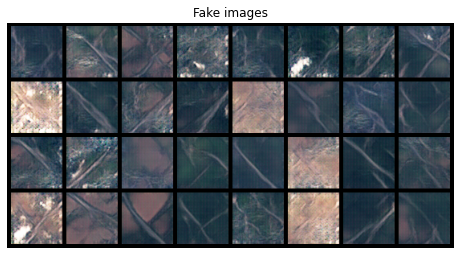

In [7]:
hw_img_list, hw_fake_data = hw_model.generate_samples(
    nb_samples=1300,
    num_classes = None,
    real_image_a = None,
    real_image_b = None
)

plot_image(hw_img_list, number=32)

### Blue Highway model

In [8]:
bl_hw_model = torch.load(f"gan_model/gan_blue_highway.pth")

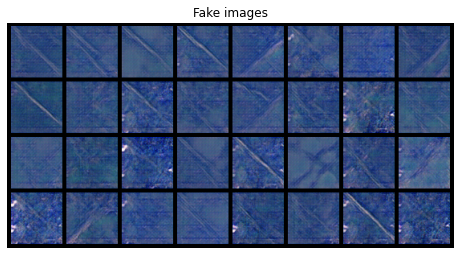

In [9]:
bl_hw_img_list, bl_hw_fake_data = bl_hw_model.generate_samples(
    nb_samples=1300,
    num_classes = None,
    real_image_a = None,
    real_image_b = None
)

plot_image(bl_hw_img_list, number=32)

### River model

In [10]:
rv_model = torch.load(f"gan_model/gan_river.pth")

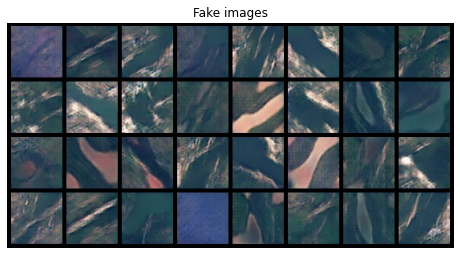

In [11]:
rv_img_list, rv_fake_data = rv_model.generate_samples(
    nb_samples=1300,
    num_classes = None,
    real_image_a = None,
    real_image_b = None
)

plot_image(rv_img_list, number=32)

### Blue River model

In [12]:
bl_rv_model = torch.load(f"gan_model/gan_blue_river.pth")

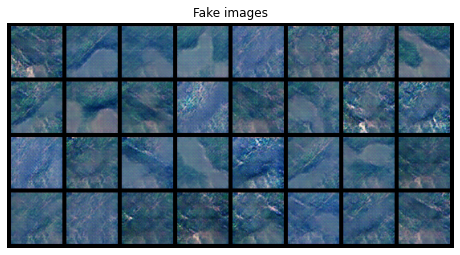

In [13]:
bl_rv_img_list, bl_rv_fake_data = bl_rv_model.generate_samples(
    nb_samples=1300,
    num_classes = None,
    real_image_a = None,
    real_image_b = None
)

plot_image(bl_rv_img_list, number=32)

## FDA

In [14]:
def denorm(tensor):
    std = torch.Tensor((0.5,)).reshape(-1, 1, 1)
    mean = torch.Tensor((0.5,)).reshape(-1, 1, 1)
    res = torch.clamp(tensor * std + mean, 0, 1)
    return res

### Blue highway

In [15]:
hw_list = denorm(hw_img_list[0])

In [16]:
gen_bl_hw_func = FdaGenerate()

gen_blue_highway = gen_bl_hw_func(
    dataset=hw_list, style_img=blue_highway_images[15],
    number_img=1300, beta=0.0157
)

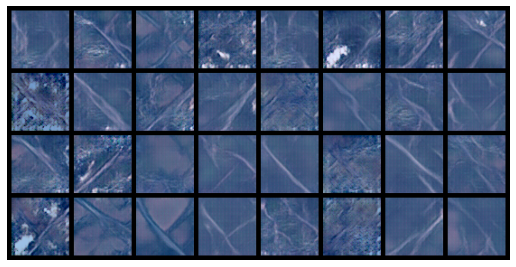

In [17]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_highway[:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

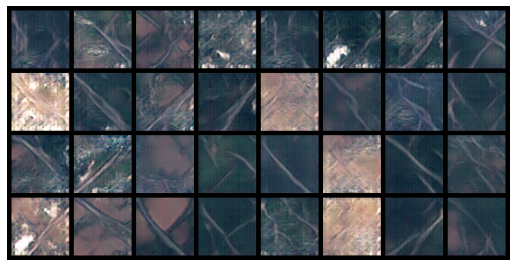

In [18]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(hw_img_list[0][:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

### Blue river

In [19]:
rv_list = denorm(rv_img_list[0])

In [20]:
gen_bl_rv_func = FdaGenerate()

gen_blue_river = gen_bl_rv_func(
    dataset=rv_list, style_img=blue_river_images[22],
    number_img=1300, beta=0.0157
)

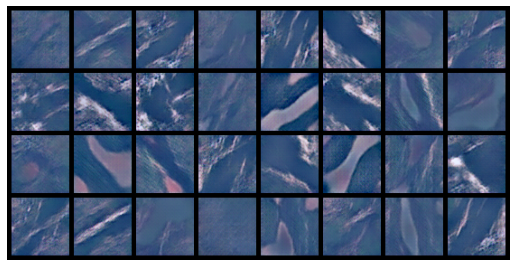

In [21]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_river[:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

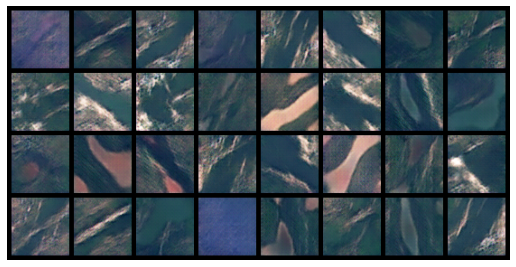

In [22]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(rv_img_list[0][:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [23]:
torch.save(gen_blue_highway, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/DCGAN_FDA/dcgan_fda_bl_hw.pt")
torch.save(gen_blue_river, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/DCGAN_FDA/dcgan_fda_bl_rv.pt")

## Flow

### Blue highway

In [24]:
torch.cuda.empty_cache()

In [25]:
trans = transforms.Compose([transforms.Resize((300,400))])

In [26]:
blue_highway_images = torch.from_numpy(blue_highway_images).float()
blue_highway_labels = torch.from_numpy(blue_highway_labels).float()

blue_river_images = torch.from_numpy(blue_river_images).float()
blue_river_labels = torch.from_numpy(blue_river_labels).float()

In [27]:
indices_bl_rv = torch.tensor([5,6,7,8,11,12,14,16,17,19,20,21,22,24,28,29,30,31,32,36,37,40,41,45,50,52,57,59,60,63,64,65,69,70,71,73,75,77,78,79])
blue_river_images_flow = torch.index_select(blue_river_images, 0, indices_bl_rv)

In [28]:
highway_images_flow = trans(hw_list[torch.randint(len(hw_list), (len(blue_highway_images),))])
blue_highway_images_flow = trans(blue_highway_images)

river_images_flow = trans(rv_list[torch.randint(len(rv_list), (len(blue_river_images_flow),))])
blue_river_images_flow = trans(blue_river_images_flow)

In [29]:
hw_train_dataset = data.TensorDataset(highway_images_flow, blue_highway_images_flow)

rv_train_dataset = data.TensorDataset(river_images_flow, blue_river_images_flow)

In [30]:
from torch.utils.data.sampler import Sampler

class DistributedGivenIterationSampler(Sampler):
    def __init__(self, dataset, total_iter, batch_size, world_size=None, rank=None, last_iter=-1):
        self.dataset = dataset
        self.total_iter = total_iter
        self.batch_size = batch_size
        self.world_size = world_size
        self.rank = rank
        self.last_iter = last_iter

        self.total_size = self.total_iter*self.batch_size

        self.indices = self.gen_new_list()
        self.call = 0

    def __iter__(self):
        if self.call == 0:
            self.call = 1
            return iter(self.indices[(self.last_iter+1)*self.batch_size:])
        else:
            raise RuntimeError("this sampler is not designed to be called more than once!!")

    def gen_new_list(self):

        # each process shuffle all list with same seed, and pick one piece according to rank
        np.random.seed(0)

        all_size = self.total_size * self.world_size
        indices = np.arange(len(self.dataset))
        indices = indices[:all_size]
        num_repeat = (all_size-1) // indices.shape[0] + 1
        indices = np.tile(indices, num_repeat)
        indices = indices[:all_size]

        np.random.shuffle(indices)
        beg = self.total_size * self.rank
        indices = indices[beg:beg+self.total_size]
        #print('len: ',len(indices))
        #print('total: ',self.total_size)
        assert len(indices) == self.total_size

        return indices

    def __len__(self):
        # note here we do not take last iter into consideration, since __len__
        # should only be used for displaying, the correct remaining size is
        # handled by dataloader
        #return self.total_size - (self.last_iter+1)*self.batch_size
        return self.total_size

In [31]:
hw_train_sampler = DistributedGivenIterationSampler(hw_train_dataset,
        5000, 1, world_size=1, rank=0, last_iter=-1)

rv_train_sampler = DistributedGivenIterationSampler(rv_train_dataset,
        5000, 1, world_size=1, rank=0, last_iter=-1)

In [32]:
hw_train_loader = data.DataLoader(
        hw_train_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=False,
        sampler=hw_train_sampler)

rv_train_loader = data.DataLoader(
        rv_train_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=False,
        sampler=rv_train_sampler)

In [33]:
torch.cuda.empty_cache()

In [34]:
vgg_path = '/home/vuong.nguyen/vuong/augmentare/augmentare/methods/style_transfer/model/vgg_normalised_flow.pth'

In [35]:
gen_bl_hw_func = StyleflowGenerate(hw_train_loader, device)

gen_blue_highway = gen_bl_hw_func(
    dataset=hw_list, style_img=blue_highway_images[15],
    number_img=1300, vgg_path=vgg_path
)

[0/5000 Stylizations], 	Loss: 0.5479236245155334
[500/5000 Stylizations], 	Loss: 0.06321737915277481
[1000/5000 Stylizations], 	Loss: 0.06908559799194336
[1500/5000 Stylizations], 	Loss: 0.04231076315045357
[2000/5000 Stylizations], 	Loss: 0.03587547689676285
[2500/5000 Stylizations], 	Loss: 0.04764170199632645
[3000/5000 Stylizations], 	Loss: 0.02183658257126808
[3500/5000 Stylizations], 	Loss: 0.04455902799963951
[4000/5000 Stylizations], 	Loss: 0.029770443215966225
[4500/5000 Stylizations], 	Loss: 0.03558444604277611


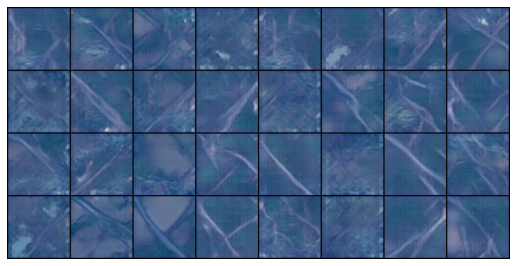

In [36]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_highway[:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

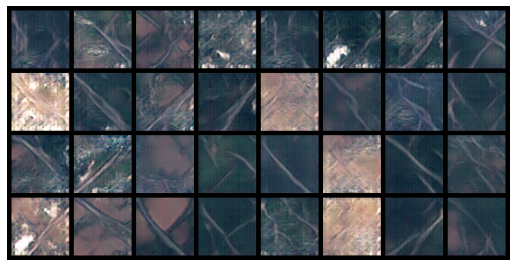

In [37]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(hw_img_list[0][:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

### Blue river

In [38]:
gen_bl_rv_func = StyleflowGenerate(rv_train_loader, device)

gen_blue_river = gen_bl_rv_func(
    dataset=rv_list, style_img=blue_river_images[22],
    number_img=1300, vgg_path=vgg_path
)

[0/5000 Stylizations], 	Loss: 0.4011465311050415
[500/5000 Stylizations], 	Loss: 0.05506289377808571
[1000/5000 Stylizations], 	Loss: 0.043942082673311234
[1500/5000 Stylizations], 	Loss: 0.04193482920527458
[2000/5000 Stylizations], 	Loss: 0.04804714024066925
[2500/5000 Stylizations], 	Loss: 0.03350089117884636
[3000/5000 Stylizations], 	Loss: 0.026149284094572067
[3500/5000 Stylizations], 	Loss: 0.022394360974431038
[4000/5000 Stylizations], 	Loss: 0.026424704119563103
[4500/5000 Stylizations], 	Loss: 0.04464379698038101


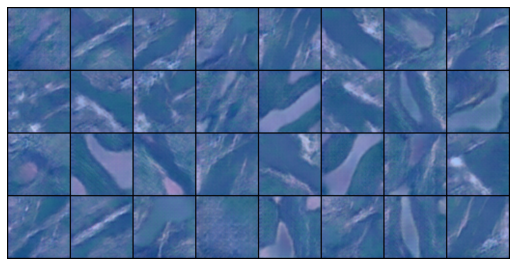

In [39]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_river[:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

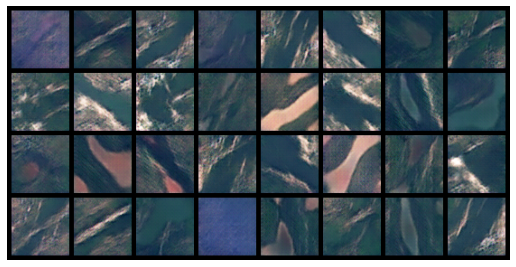

In [40]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(rv_img_list[0][:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [41]:
torch.save(gen_blue_highway, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/DCGAN_Flow/dcgan_flow_bl_hw.pt")
torch.save(gen_blue_river, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/DCGAN_Flow/dcgan_flow_bl_rv.pt")

## CCPL

### Blue highway

In [101]:
torch.cuda.empty_cache()

In [102]:
highway_images = X_train[np.where(y_train==0)]
highway_labels = y_train[np.where(y_train==0)]

river_images = X_train[np.where(y_train==1)]
river_labels = y_train[np.where(y_train==1)]

In [103]:
highway_images = torch.from_numpy(highway_images).float()
highway_labels = torch.from_numpy(highway_labels).float()

river_images = torch.from_numpy(river_images).float()
river_labels = torch.from_numpy(river_labels).float()

In [104]:
trans = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomCrop(256)
])

In [105]:
indices_bl_rv = torch.tensor([5,6,7,8,11,12,14,16,17,19,20,21,22,24,28,29,30,31,32,36,37,40,41,45,50,52,57,59,60,63,64,65,69,70,71,73,75,77,78,79])
blue_river_images_ccpl = torch.index_select(blue_river_images, 0, indices_bl_rv)

In [106]:
highway_images_ccpl = trans(highway_images[torch.randint(len(highway_images), (len(blue_highway_images),))])
blue_highway_images_ccpl = trans(blue_highway_images)

river_images_ccpl = trans(river_images[torch.randint(len(river_images), (len(blue_river_images_ccpl),))])
blue_river_images_ccpl = trans(blue_river_images_ccpl)

In [107]:
from torch.utils.data.sampler import Sampler

def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0

class InfiniteSamplerWrapper(Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

In [108]:
hw_content_images = data.DataLoader(
    highway_images_ccpl, batch_size=8,
    sampler=InfiniteSamplerWrapper(highway_images_ccpl),
    num_workers=16)

hw_style_images = data.DataLoader(
    blue_highway_images_ccpl, batch_size=8,
    sampler=InfiniteSamplerWrapper(blue_highway_images_ccpl),
    num_workers=16)

In [109]:
rv_content_images = data.DataLoader(
    river_images_ccpl, batch_size=8,
    sampler=InfiniteSamplerWrapper(river_images_ccpl),
    num_workers=16)

rv_style_images = data.DataLoader(
    blue_river_images_ccpl, batch_size=8,
    sampler=InfiniteSamplerWrapper(blue_river_images_ccpl),
    num_workers=16)

In [110]:
vgg_path = '/home/vuong.nguyen/vuong/augmentare/augmentare/methods/style_transfer/model/vgg_normalised_ccpl.pth'

In [114]:
gen_bl_hw_func = CcplGenerate(
    con_img_train=hw_content_images, sty_img_train=hw_style_images,
    device=device
)

gen_blue_highway = gen_bl_hw_func(
    dataset=hw_list, style_img=blue_highway_images[15],
    number_img=1300, max_iter=5000, vgg_path=vgg_path
)

100%|██████████| 5000/5000 [07:45<00:00, 10.75it/s]


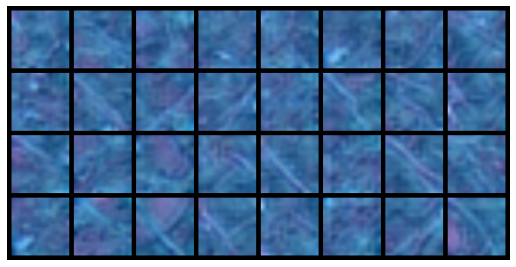

In [115]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_highway[:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

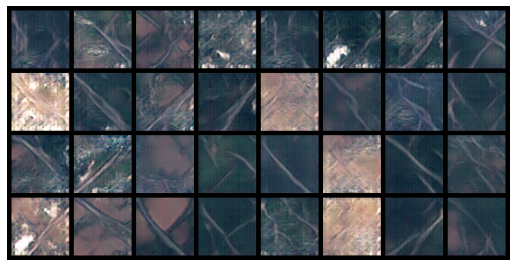

In [116]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(hw_img_list[0][:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

### Blue river

In [117]:
gen_bl_rv_func = CcplGenerate(
    con_img_train=rv_content_images, sty_img_train=rv_style_images,
    device=device
)

gen_blue_river = gen_bl_rv_func(
    dataset=rv_list, style_img=blue_river_images[22],
    number_img=1300, max_iter=2500, vgg_path=vgg_path
)

100%|██████████| 2500/2500 [03:50<00:00, 10.84it/s]


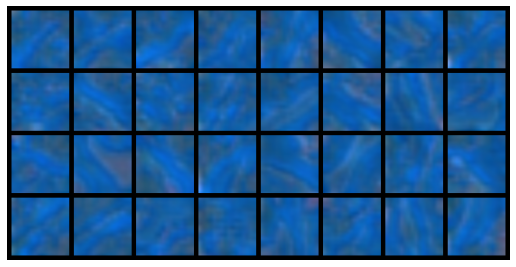

In [118]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(gen_blue_river[:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

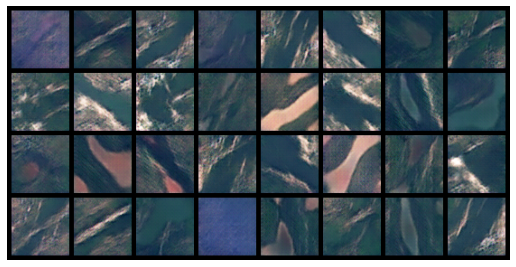

In [119]:
# Set nrow=5, and padding=20
Grid_hw = make_grid(rv_img_list[0][:32], padding=5, normalize=True)
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(Grid_hw.cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [ ]:
torch.save(gen_blue_highway, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/DCGAN_CCPL/dcgan_ccpl_bl_hw.pt")
torch.save(gen_blue_river, "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/DCGAN_CCPL/dcgan_ccpl_bl_rv.pt")